## Preparing Image Data

In [6]:
# pixel normalization
from numpy import asarray
from PIL import Image
# load image
image = Image.open('bondi_beach.jpg')
pixels = asarray(image)
# confirm range 0-255
print("=== Confirming Range ===")
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from int to float
pixels = pixels.astype('float32')
# normalize 0-1
pixels /= 255.0
print("=== Normalizing ===")
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

# We have normalized the values, but we can also standardize them,
# transforming the distribution to a standard Gaussian (centering
# the pixel values on zero and normalizing w/ standard deviation)

# get mean and standard deviation
mean, std = pixels.mean(), pixels.std()
print("=== Standardizing ===")
print('Mean: %.3f, Std Dev: %.3f' % (mean, std))
# standardize
pixels = (pixels - mean) / std
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Std Dev: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# this introduces a potential issue where our min is negative and our max is over 1
# we can clip to -1 and 1 and rescale to 0 and 1
from numpy import clip
pixels = clip(pixels, -1.0, 1.0)
pixels = (pixels + 1.0) / 2.0
mean, std = pixels.mean(), pixels.std()
print("=== Clipping ===")
print('Mean: %.3f, Std Dev: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

=== Confirming Range ===
Data Type: uint8
Min: 0.000, Max: 255.000
=== Normalizing ===
Min: 0.000, Max: 1.000
=== Standardizing ===
Mean: 0.610, Std Dev: 0.202
Mean: 0.000, Std Dev: 1.000
Min: -3.019, Max: 1.930
=== Clipping ===
Mean: 0.539, Std Dev: 0.377
Min: 0.000, Max: 1.000


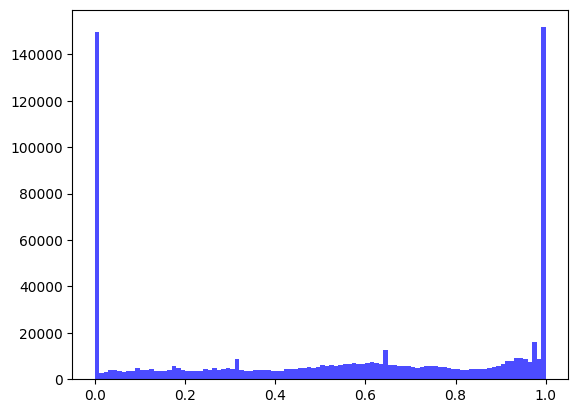

In [7]:
# Now let's look at our distribution
import matplotlib.pyplot as plt
pixels = pixels.flatten()
plt.hist(pixels,bins=100,color='blue',alpha=0.7)
plt.show()

Means: [131.41411007 153.1192257  182.1233387 ], Stds: [58.18740883 40.11213778 40.92859711]
Means: [ 6.47491987e-16  1.21311307e-12 -1.03400083e-13], Stds: [1. 1. 1.]


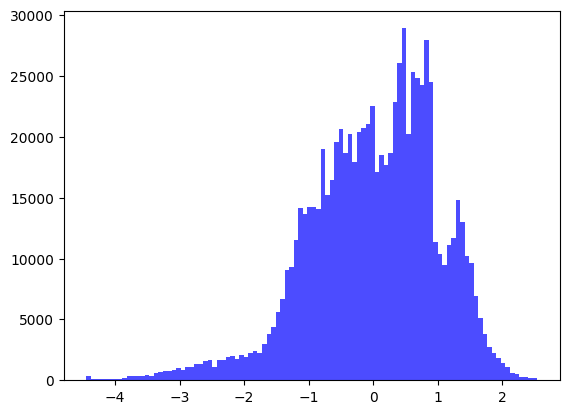

In [8]:
# We can also look at local standardization and calculate the mean and std dev per channel

# load image
image = Image.open('bondi_beach.jpg')
pixels = asarray(image)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))
# per-channel standardization of pixels
pixels = (pixels - means) / stds
# confirm it had the desired effect
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))
pixels = pixels.flatten()
plt.hist(pixels,bins=100,color='blue',alpha=0.7)
plt.show()


## CNN

Convolution: Application of a filter to an input that results in an activation. Repeated applications of the same filter to an input results in a map of activations called a feature map. A convolutional layer can be created by specifying the number of filters to learn and the fixed size of each filter (kernel shape)

Pooling: Downsampling feature maps by summarizing the presence of features in patches of the feature map. Max pooling calculate the maximum value in each patch of each feature map

Classifier Layer: Flatten the 2-dim feature maps and add a fully connected output layer. For binary classification the output layer would have one node that would predict a value between 0 and 1 for the two classes. For multi-class classification the output layer would have a node for each class with a value between 0 and 1 for the probability that class is correct.

In [9]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [10]:
# Using Keras
# CNN with single convolutional, pooling, and output layer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# create model
model = Sequential()
# add convolutional layer
model.add(Conv2D(32, (3,3), input_shape=(256,256,1)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

2024-05-09 13:36:45.660151: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 13:36:45.673115: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 13:36:46.118804: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 13:36:47.713407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 13:36:54.988363: W tensorflow/compiler/tf2tensorrt/utils/py_uti

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       516,129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516,449 (1.97 MB)

 Trainable params: 516,449 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

## Image Classification

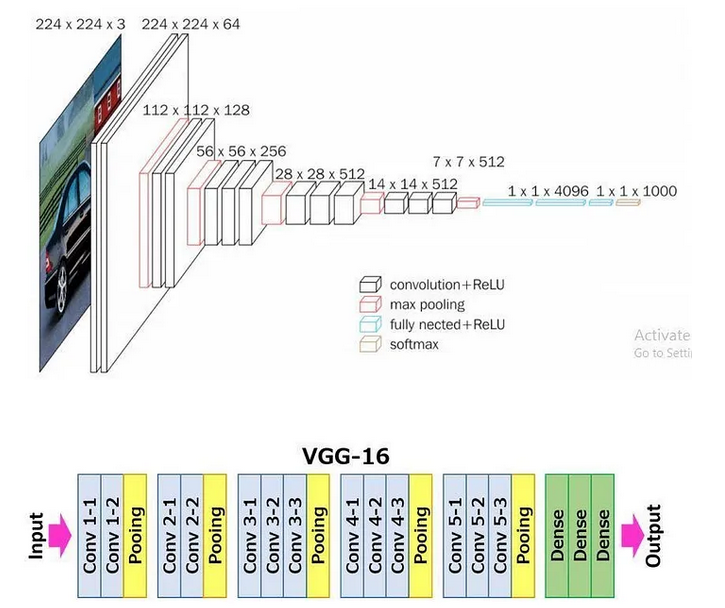

In [11]:
# using pre-trained model
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
# VGG-16 is a 16 layer CNN used for object detection and classification
# able to classify 1000 images of 1000 different categories with 92.7% accuracy
# 13 convolution layers, 5 max-pooling layers, and 3 dense layers (21 layers) but only 16 have learnable weights

def predict(image_path):
    image = load_img(image_path, target_size=(224, 224)) # input size for VGG-16 architecture
    image = asarray(image) # convert to np array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image) # preprocess
    model = VGG16() # load model
    yhat = model.predict(image) # predict probabilities on output classes
    label = decode_predictions(yhat) # convert to label
    label = label[0][0]
    print('%s (%.2f%%)' % (label[1], label[2]*100))

In [12]:
predict('dog.jpg')
predict('cat.jpg')
predict('bondi_beach.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Doberman (36.90%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Siamese_cat (94.47%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
seashore (74.18%)


## Training a Classification Model

Fashion-MNIST
60,000 small 28x28 grayscale images of 10 different clothing classes.

In [13]:
# fit a CNN on fashion-mnist
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# keras already has the dataset partitioned into train and test
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# reshape for a single channel
print("TrainX: %s, TestX: %s" % (trainX.shape, testX.shape))
trainX = trainX.reshape((trainX.shape[0],28,28,1))
testX = testX.reshape((testX.shape[0],28,28,1))
print("TrainX: %s, TestX: %s" % (trainX.shape, testX.shape))

# convert to float
trainX, testX = trainX.astype('float32'), testX.astype('float32')

# normalize from 0-1
trainX, testX = trainX/255.0, testX/255.0

# one hot encoding
trainY, testY = to_categorical(trainY), to_categorical(testY)

# define model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fit model
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2)

# eval
loss, acc = model.evaluate(testX, testY, verbose=0)
print("Loss: %.3f, Acc: %.3f" % (loss, acc*100))


TrainX: (60000, 28, 28), TestX: (10000, 28, 28)
TrainX: (60000, 28, 28, 1), TestX: (10000, 28, 28, 1)
Epoch 1/10
1875/1875 - 6s - 3ms/step - accuracy: 0.8632 - loss: 0.3827
Epoch 2/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9062 - loss: 0.2571
Epoch 3/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9223 - loss: 0.2117
Epoch 4/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9353 - loss: 0.1781
Epoch 5/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9445 - loss: 0.1497
Epoch 6/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9519 - loss: 0.1300
Epoch 7/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9599 - loss: 0.1086
Epoch 8/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9656 - loss: 0.0944
Epoch 9/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9711 - loss: 0.0800
Epoch 10/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9743 - loss: 0.0690
Loss: 0.333, Acc: 90.930


## Image Augmentation

This can be used to artificially expand a training dataset by creating modified versions of images

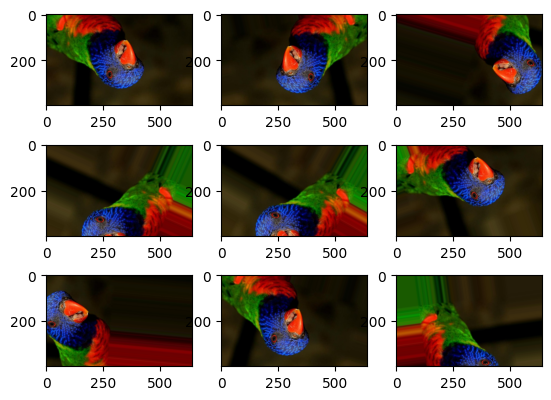

In [29]:
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

img = load_img('bird.jpg')
data = img_to_array(img)

# expand dimension to one sample
samples = expand_dims(data, 0)

# create image data aug generator
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)

# prepare iterator
for i, batch in enumerate(datagen.flow(samples, batch_size=1)):
    if i > 8:
        break
    plt.subplot(3,3,i+1)
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()